# Import Libraries

In [39]:
import os # Library for accessing the file system
import cv2 # Library for image processing
import matplotlib.pyplot as plt # Library for data visualization
import numpy as np # Library for numerical computations
import pandas as pd # Library for data manipulation and analysis
from tqdm import tqdm # Library for progress bar
import tensorflow as tf # Library used for building the neural network
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Reshape # Layers for building neural network
from keras.models import Model # Framework for building neural network
from keras.optimizers import Adam # Optimizer for gradient descent
from keras.preprocessing.image import ImageDataGenerator # Utility for loading images and performing data augmentation
from keras_preprocessing.image import array_to_img # Library to convert NumPy array to a PIL.Image.Image object
from keras.utils import to_categorical, load_img, img_to_array # Utility for converting labels to categorical values, etc
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve # Utility for evaluating model performance
from sklearn.model_selection import train_test_split # Utility for splitting data into training and testing sets
import seaborn as sns # Library for data visualization

# Data Analysis

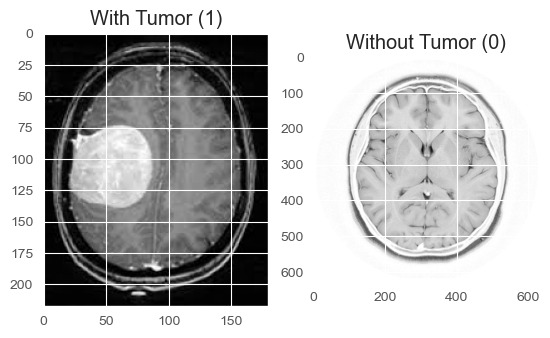

In [40]:
# Define the path to the dataset
dataset_path = "./brain_tumor_dataset"

# Load MRI images
image1 = plt.imread('./brain_tumor_dataset/yes/Y1.jpg')
image2 = plt.imread('./brain_tumor_dataset/no/1 no.jpeg')

# Display images side by side
fig, ax = plt.subplots(1, 2) # create a figure with one row and two columns of subplots
ax[0].imshow(image1, cmap='binary') # show the first image on the first subplot
ax[0].set_title('With Tumor (1)') # set the title of the first subplot
ax[1].imshow(image2, cmap='binary') # show the second image on the second subplot
ax[1].set_title('Without Tumor (0)') # set the title of the second subplot
plt.show() # display the figure

# Data Preprocess

In [41]:
# Initialize the hyperparameters
it = 3 # Number of iterations completed to retrain
INIT_LR = 1e-4 # Learning rate
EPOCHS = 20 # Number of epochs
BS = 32 # Batch size

In [42]:
# Define the data augmentation object with the desired parameters
new_aug = ImageDataGenerator(
    horizontal_flip=True, # Randomly flip the image horizontally
    vertical_flip=True, # Randomly flip the image vertically
)

# Define data augmentation generators
new_aug_generator = new_aug.flow_from_directory(
    dataset_path,
    batch_size=BS,
    class_mode='binary',
    shuffle=False
)

# Save images from train generator with progress bar
for i in tqdm(range(len(new_aug_generator.filenames))):
    # Load the next image from the generator
    img_path = os.path.join(dataset_path, new_aug_generator.filenames[i])
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate augmented images for the current image
    class_name = 'no' if new_aug_generator.labels[i] == 0 else 'yes'
    new_aug_images = new_aug.flow(x, batch_size=1, save_format='png')

    # Save each augmented image to the corresponding class directory
    for j in range(len(new_aug_images)):
        img_array = new_aug_images[j].reshape(new_aug_images[j].shape[1:])
        img = array_to_img(img_array)
        if class_name == 'no':
            img.save(os.path.join(dataset_path, class_name, f"{i}_0.png"))
        else:
            img.save(os.path.join(dataset_path, class_name, f"{i}_1.png"))

Found 1306 images belonging to 2 classes.


100%|██████████| 1306/1306 [01:07<00:00, 19.37it/s]


In [43]:
# Load the image data and labels
data = [] # initialize empty list to store image data
labels = [] # initialize empty list to store corresponding labels

# Iterate through each category in ["no", "yes"]
for category in ["no", "yes"]:
    path = os.path.join(dataset_path, category) # set the path to the directory containing the images for this category
    for img in os.listdir(path): # iterate through each image file in the directory
        img_path = os.path.join(path, img) # set the full file path for the image
        image = cv2.imread(img_path) # read the image data into a numpy array
        image = cv2.resize(image, (224, 224)) # resize the image to (224,224)
        data.append(image) # add the image data to the list of data
        if category == "no":
            labels.append(0)
        else:
            labels.append(1)

# Print the data and labels lists
print(data)
print(labels)

[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,

In [44]:
# Convert the data and labels lists to NumPy arrays
data = np.array(data)   # convert the list 'data' to a NumPy array and store it in a variable called 'data'
labels = np.array(labels)   # convert the list 'labels' to a NumPy array and store it in a variable called 'labels'

# Print the NumPy arrays
print(data)   # print the NumPy array 'data'
print(labels)   # print the NumPy array 'labels'

[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0

In [45]:
# Perform one-hot encoding on the labels
labels = to_categorical(labels)

# Print the one-hot encoded labels
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [46]:
# Split the data using the train_test_split function and store the results in variables
(trainX, testX, trainY, testY) = train_test_split(
    data, # dataset to be split
    labels, # corresponding labels
    test_size=0.2, # 20% of the data will be used for testing and 80% for training
    stratify=labels, # ensures that the ratio of classes in the original dataset is maintained in both the training and testing datasets
    random_state=None # set the random seed for reproducibility
)

(trainX, validX, trainY, validY) = train_test_split(
    trainX, # dataset to be split
    trainY, # corresponding labels
    test_size=0.2, # 20% of the data will be used for validation and 80% for training
    stratify=trainY, # ensures that the ratio of classes in the original dataset is maintained in both the training and validation datasets
    random_state=None # set the random seed for reproducibility
)

# Print the number of samples in each set
print(f"Number of training samples: {len(trainX)}")
print(f"Number of validating samples: {len(validX)}")
print(f"Number of testing samples: {len(testX)}")

Number of training samples: 1185
Number of validating samples: 297
Number of testing samples: 371


# Model Retraining

In [47]:
# Load the pre-trained model
baseModel = tf.keras.models.load_model('./MNV2_Model.h5')

# View the baseModel summary
baseModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [49]:
# Define the head of the model that will be placed on top of the base model
headModel = baseModel.output

# Reshape the head model to have a single channel
headModel = Reshape(target_shape=(1, 1, -1))(headModel)

# Add Global Average Pooling layer to the head model
headModel = GlobalAveragePooling2D()(headModel)

# Add a UNIQUE fully connected Dense layer with 128 units and a ReLU activation function
headModel = Dense(128, activation="relu", name=f"dense_{it+3}")(headModel)

# Add a Dropout layer with a rate of 0.5 to reduce overfitting
headModel = Dropout(0.5, name=f"dropout_{it}")(headModel)

# Add a fully connected Dense layer with 2 units and a softmax activation function
headModel = Dense(2, activation="softmax", name=f"dense_{it+4}")(headModel)

# View the baseModel summary
baseModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [50]:
# Define the final model
model = Model(inputs=baseModel.input, outputs=headModel)

# Define the optimizer with the specified learning rate and decay
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

# Compile the model with the binary crossentropy loss function, the defined optimizer and the accuracy metric
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# View the model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [51]:
# Train the model using augmented data
H = model.fit(
    trainX, trainY,
    validation_data=(validX, validY), # Validation data
    epochs=EPOCHS, # Number of training epochs
    batch_size=BS
)

Epoch 1/20
38/38 [==============================] - 26s 496ms/step - loss: 0.6698 - accuracy: 0.7030 - val_loss: 0.6616 - val_accuracy: 0.7340
Epoch 2/20
38/38 [==============================] - 18s 472ms/step - loss: 0.6588 - accuracy: 0.7266 - val_loss: 0.6487 - val_accuracy: 0.7340
Epoch 3/20
38/38 [==============================] - 18s 470ms/step - loss: 0.6436 - accuracy: 0.7384 - val_loss: 0.6342 - val_accuracy: 0.7340
Epoch 4/20
38/38 [==============================] - 19s 497ms/step - loss: 0.6280 - accuracy: 0.7376 - val_loss: 0.6193 - val_accuracy: 0.7340
Epoch 5/20
38/38 [==============================] - 20s 530ms/step - loss: 0.6149 - accuracy: 0.7376 - val_loss: 0.6043 - val_accuracy: 0.7340
Epoch 6/20
38/38 [==============================] - 23s 615ms/step - loss: 0.6018 - accuracy: 0.7392 - val_loss: 0.5887 - val_accuracy: 0.7340
Epoch 7/20
38/38 [==============================] - 20s 530ms/step - loss: 0.5855 - accuracy: 0.7418 - val_loss: 0.5723 - val_accuracy: 0.7340

In [52]:
# Make predictions on the test set
predictions = model.predict(testX)

# Convert the predicted probabilities to class labels
predictions = np.argmax(predictions, axis=1)

# Generate a classification report
report_dict = classification_report(testY.argmax(axis=1), predictions, output_dict=True)

# create a pandas DataFrame from the classification report dictionary
df = pd.DataFrame(report_dict)

print(df)

# save the DataFrame to a CSV file
df.to_csv(f'MNV2_Report_Retrained({it-1}).csv')

# Save the model
model.save("MNV2_Model.h5")

12/12 [==============================] - 6s 379ms/step
                   0           1  accuracy   macro avg  weighted avg
precision   0.989362    0.981949  0.983827    0.985656      0.983907
recall      0.948980    0.996337  0.983827    0.972658      0.983827
f1-score    0.968750    0.989091  0.983827    0.978920      0.983718
support    98.000000  273.000000  0.983827  371.000000    371.000000


# Result Analysis

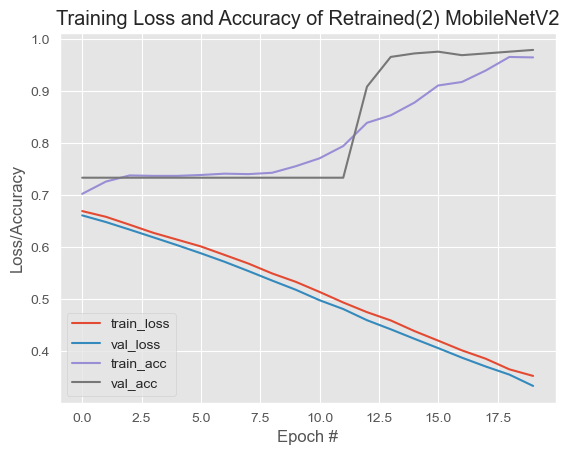

In [53]:

# This code plots the training loss and accuracy of the MobileNetV2 model.
# It uses the "ggplot" style for the plot.

# Set the style of the plot
plt.style.use("ggplot")

# Create a new figure
plt.figure()

# Add four plots to the figure: training loss, validation loss, training accuracy, and validation accuracy
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")

# Set the title of the plot
plt.title(f"Training Loss and Accuracy of Retrained({it-1}) MobileNetV2")

# Add labels to the x and y axes of the plot
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

# Add a legend to the plot in the lower left corner
plt.legend(loc="lower left")

# Save the plot as an image file
plt.savefig(f'MNV2_Loss_Accuracy_Retrained({it-1}).png')

# Display the plot on the screen
plt.show()

12/12 [==============================] - 5s 421ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0
 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0
 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1
 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1
 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1
 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1
 1]
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 

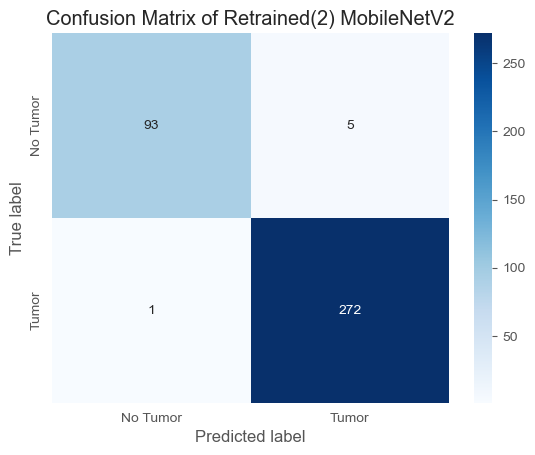

In [56]:
# This code plots the Confusion Matrix of the MobileNetV2 model.

# First, get the true and predicted labels
y_true = np.argmax(testY, axis=1)
y_pred = np.argmax(model.predict(testX), axis=1)
print(y_true)
print(y_pred)

# Then, get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = ['No Tumor', 'Tumor']

# Create a heatmap using the confusion matrix, with annotations and blue color scheme
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# Add labels and title to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f'Confusion Matrix of Retrained({it-1}) MobileNetV2')

# Save the plot as an image file
plt.savefig(f'MNV2_Confusion_Matrix_Retrained({it-1}).png')

# Display the plot
plt.show()

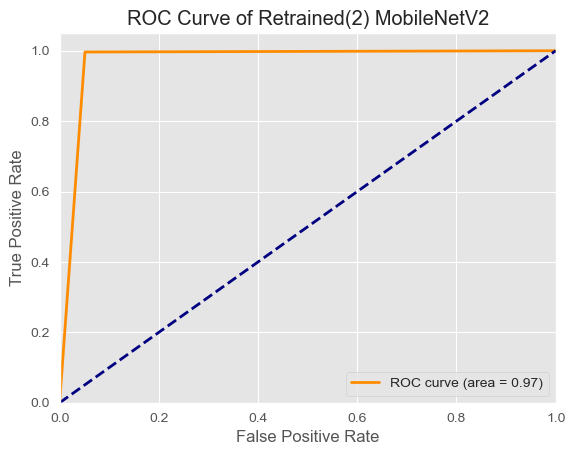

In [57]:
# Generate the ROC curve and calculate the area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve of Retrained({it-1}) MobileNetV2')
plt.legend(loc="lower right")
plt.savefig(f'MNV2_ROC_Curve_Retrained({it-1}).png')
plt.show()

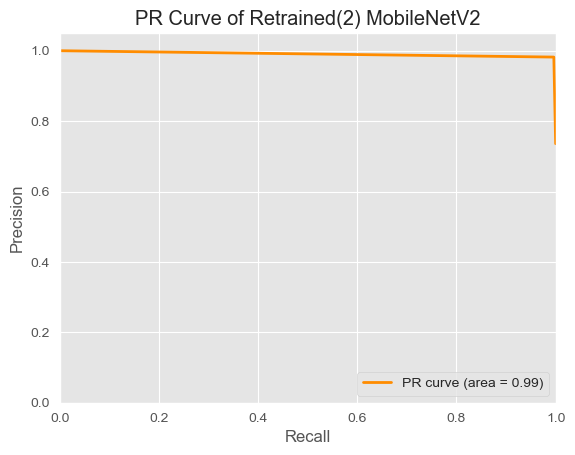

In [58]:
# Generate the precision-recall curve and calculate the area under the curve (AUC)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR Curve of Retrained({it-1}) MobileNetV2')
plt.legend(loc="lower right")
plt.savefig(f'MNV2_PreRec_Curve_Retrained({it-1}).png')
plt.show()